# Problem Statement and EDA

In [1]:
pip install category_encoders

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder

In [3]:
df = pd.read_csv("/content/ola_driver_scaler.csv")

In [4]:
df.head(20)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
5,5,12/01/19,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
6,6,01/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
7,7,02/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
8,8,03/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,350000,1
9,9,04/01/20,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,0,1


In [5]:
df['Negative TBV'] = (df['Total Business Value'] < 0).astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
 14  Negative TBV          19104 non-null  int64  
dtypes: float64(2), int6

In [7]:
# Assuming df is your DataFrame containing the data
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])

In [8]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df.isna().sum()

MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
Negative TBV                0
dtype: int64

In [10]:
unique_drivers = df['Driver_ID'].unique()
df_grouped = df.groupby('Driver_ID').agg({
    'MMM-YY': 'first',
    'Age': 'max',
    'Gender': 'first',
    'City': 'first',
    'Education_Level': 'max',
    'Income': np.mean,
    'Dateofjoining': 'first',
    'LastWorkingDate': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None,
    'Joining Designation': 'max',
    'Grade': 'max',
    'Total Business Value': 'sum',
    'Quarterly Rating': np.mean,
    'Negative TBV': 'sum'

})
df_grouped.head()

,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Negative TBV
Driver_ID,,,,,,,,,,,,,
1,2019-01-01,28.0,0.0,C23,2,57387.0,2018-12-24,2019-03-11,1,1,1715580,2.0,1
2,2020-11-01,31.0,0.0,C7,2,67016.0,2020-11-06,NaT,2,2,0,1.0,0
4,2019-12-01,43.0,0.0,C13,2,65603.0,2019-12-07,2020-04-27,2,2,350000,1.0,0
5,2019-01-01,29.0,0.0,C9,0,46368.0,2019-01-09,2019-03-07,1,1,120360,1.0,0
6,2020-08-01,31.0,1.0,C11,1,78728.0,2020-07-31,NaT,3,3,1265000,1.6,0


In [11]:
df_grouped['Negative TBV'].value_counts()

0    2245
1     125
2       9
3       2
Name: Negative TBV, dtype: int64

In [12]:
df_grouped.isna().sum()

MMM-YY                    0
Age                       0
Gender                    0
City                      0
Education_Level           0
Income                    0
Dateofjoining             0
LastWorkingDate         765
Joining Designation       0
Grade                     0
Total Business Value      0
Quarterly Rating          0
Negative TBV              0
dtype: int64

In [13]:
df_grouped.shape

(2381, 13)

In [14]:
df_grouped.duplicated().sum()

0

# Feature Engineering

In [139]:
# Convert 'Reporting Date' to datetime format
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])

# Extract quarter from 'Reporting Date'
df['Quarter'] = df['MMM-YY'].dt.to_period('Q')

# Group by 'Quarter' and calculate the sum of 'Total Business Value'
quarterly_total_business_value = df.groupby(['Driver_ID', 'Quarter'])['Total Business Value'].sum()

# Reset index to make 'Quarter' a column instead of index
quarterly_total_business_value = quarterly_total_business_value.reset_index()

# Display the aggregated quarterly total business value
print(quarterly_total_business_value)

      Driver_ID Quarter  Total Business Value
0             1  2019Q1               1715580
1             2  2020Q4                     0
2             4  2019Q4               3150000
3             5  2019Q1                120360
4             6  2020Q3               5060000
...         ...     ...                   ...
2376       2784  2019Q1            1391924480
2377       2785  2020Q3                     0
2378       2786  2019Q1              25335810
2379       2787  2019Q1               3911320
2380       2788  2020Q2              20684160

[2381 rows x 3 columns]


In [15]:
def qrt_rat_inc(rating):
    if len(rating) >= 2:
        return int(rating.iloc[-1] > rating.iloc[-2])
    else:
        return 0

Quarterly_Rating_increased = df.groupby("Driver_ID")["Quarterly Rating"].apply(qrt_rat_inc).reset_index(name='Quarterly_Rating_increased')

df_grouped = pd.merge(left=df_grouped,
                right=Quarterly_Rating_increased,
                on="Driver_ID",
                how="outer")

df_grouped['Quarterly_Rating_increased'].value_counts()

0    2365
1      16
Name: Quarterly_Rating_increased, dtype: int64

In [16]:
def inc_income(inc):
    if len(inc) >= 2:
        return int(inc.iloc[-1] > inc.iloc[-2])
    else:
        return 0

Increased_income = df.groupby("Driver_ID")["Income"].apply(inc_income).reset_index(name='Increased_income')

df_grouped = pd.merge(left=df_grouped,
                right=Increased_income,
                on="Driver_ID",
                how="outer")

df_grouped['Increased_income'].value_counts()

0    2370
1      11
Name: Increased_income, dtype: int64

In [17]:
def inc_education(edu):
  if len(edu)>=2:
    return int(edu.iloc[-1]>edu.iloc[-2])
  else:
    return 0

Increased_education = df.groupby("Driver_ID")["Education_Level"].apply(inc_education).reset_index(name='Increased_education')

df_grouped = pd.merge(left=df_grouped,
                right=Increased_education,
                on="Driver_ID",
                how="outer")

df_grouped['Increased_education'].value_counts()

0    2381
Name: Increased_education, dtype: int64

In [18]:
# Grade Increament
def inc_grade(grd):
  if len(grd)>=2:
    return int(grd.iloc[-1]>grd.iloc[-2])
  else:
    return 0

Increased_grade = df.groupby("Driver_ID")["Grade"].apply(inc_education).reset_index(name='Increased_grade')

df_grouped = pd.merge(left=df_grouped,
                right=Increased_grade,
                on="Driver_ID",
                how="outer")

df_grouped['Increased_grade'].value_counts()

0    2370
1      11
Name: Increased_grade, dtype: int64

In [19]:
# Grade Decreament
def dec_grade(grd):
  if len(grd)>=2:
    return int(grd.iloc[-1]<grd.iloc[-2])
  else:
    return 0

Decreased_grade = df.groupby("Driver_ID")["Grade"].apply(dec_grade).reset_index(name='Decreased_grade')

df_grouped = pd.merge(left=df_grouped,
                right=Decreased_grade,
                on="Driver_ID",
                how="outer")

df_grouped['Decreased_grade'].value_counts()

0    2380
1       1
Name: Decreased_grade, dtype: int64

In [20]:
# Income Decreament
def dec_income(inc):
    if len(inc) >= 2:
        return int(inc.iloc[-1] < inc.iloc[-2])
    else:
        return 0

Decreased_income = df.groupby("Driver_ID")["Income"].apply(dec_income).reset_index(name='Decreased_income')

df_grouped = pd.merge(left=df_grouped,
                right=Decreased_income,
                on="Driver_ID",
                how="outer")

df_grouped['Decreased_income'].value_counts()

0    2380
1       1
Name: Decreased_income, dtype: int64

In [21]:
# City Change
def city_change(chg):
  if len(chg.unique())>=2:
    return 1
  else:
    return 0

City_change = df.groupby("Driver_ID")["City"].apply(city_change).reset_index(name='City_change')

df_grouped = pd.merge(left=df_grouped,
                right=City_change,
                on="Driver_ID",
                how="outer")

df_grouped['City_change'].value_counts()

0    2381
Name: City_change, dtype: int64

In [22]:
df_grouped=df_grouped.drop(['City_change', 'Increased_education', 'Decreased_income', 'Decreased_grade'], axis=1)

In [23]:
df_grouped['JoiningYear']=df_grouped['Dateofjoining'].dt.year

In [24]:
df_grouped['target'] = df_grouped['LastWorkingDate'].notnull().astype(int)

In [25]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Driver_ID                   2381 non-null   int64         
 1   MMM-YY                      2381 non-null   datetime64[ns]
 2   Age                         2381 non-null   float64       
 3   Gender                      2381 non-null   float64       
 4   City                        2381 non-null   object        
 5   Education_Level             2381 non-null   int64         
 6   Income                      2381 non-null   float64       
 7   Dateofjoining               2381 non-null   datetime64[ns]
 8   LastWorkingDate             1616 non-null   datetime64[ns]
 9   Joining Designation         2381 non-null   int64         
 10  Grade                       2381 non-null   int64         
 11  Total Business Value        2381 non-null   int64       

In [26]:
df_grouped.head()

,Driver_ID,MMM-YY,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Negative TBV,Quarterly_Rating_increased,Increased_income,Increased_grade,JoiningYear,target
0,1,2019-01-01,28.0,0.0,C23,2,57387.0,2018-12-24,2019-03-11,1,1,1715580,2.0,1,0,0,0,2018,1
1,2,2020-11-01,31.0,0.0,C7,2,67016.0,2020-11-06,NaT,2,2,0,1.0,0,0,0,0,2020,0
2,4,2019-12-01,43.0,0.0,C13,2,65603.0,2019-12-07,2020-04-27,2,2,350000,1.0,0,0,0,0,2019,1
3,5,2019-01-01,29.0,0.0,C9,0,46368.0,2019-01-09,2019-03-07,1,1,120360,1.0,0,0,0,0,2019,1
4,6,2020-08-01,31.0,1.0,C11,1,78728.0,2020-07-31,NaT,3,3,1265000,1.6,0,0,0,0,2020,0


In [27]:
df_grouped['target'].value_counts()

1    1616
0     765
Name: target, dtype: int64

# Data Visualization

## Univariate Analysis

In [28]:
Driver_ID = df_grouped['Driver_ID']
df_grouped=df_grouped.drop(['Driver_ID'], axis=1)

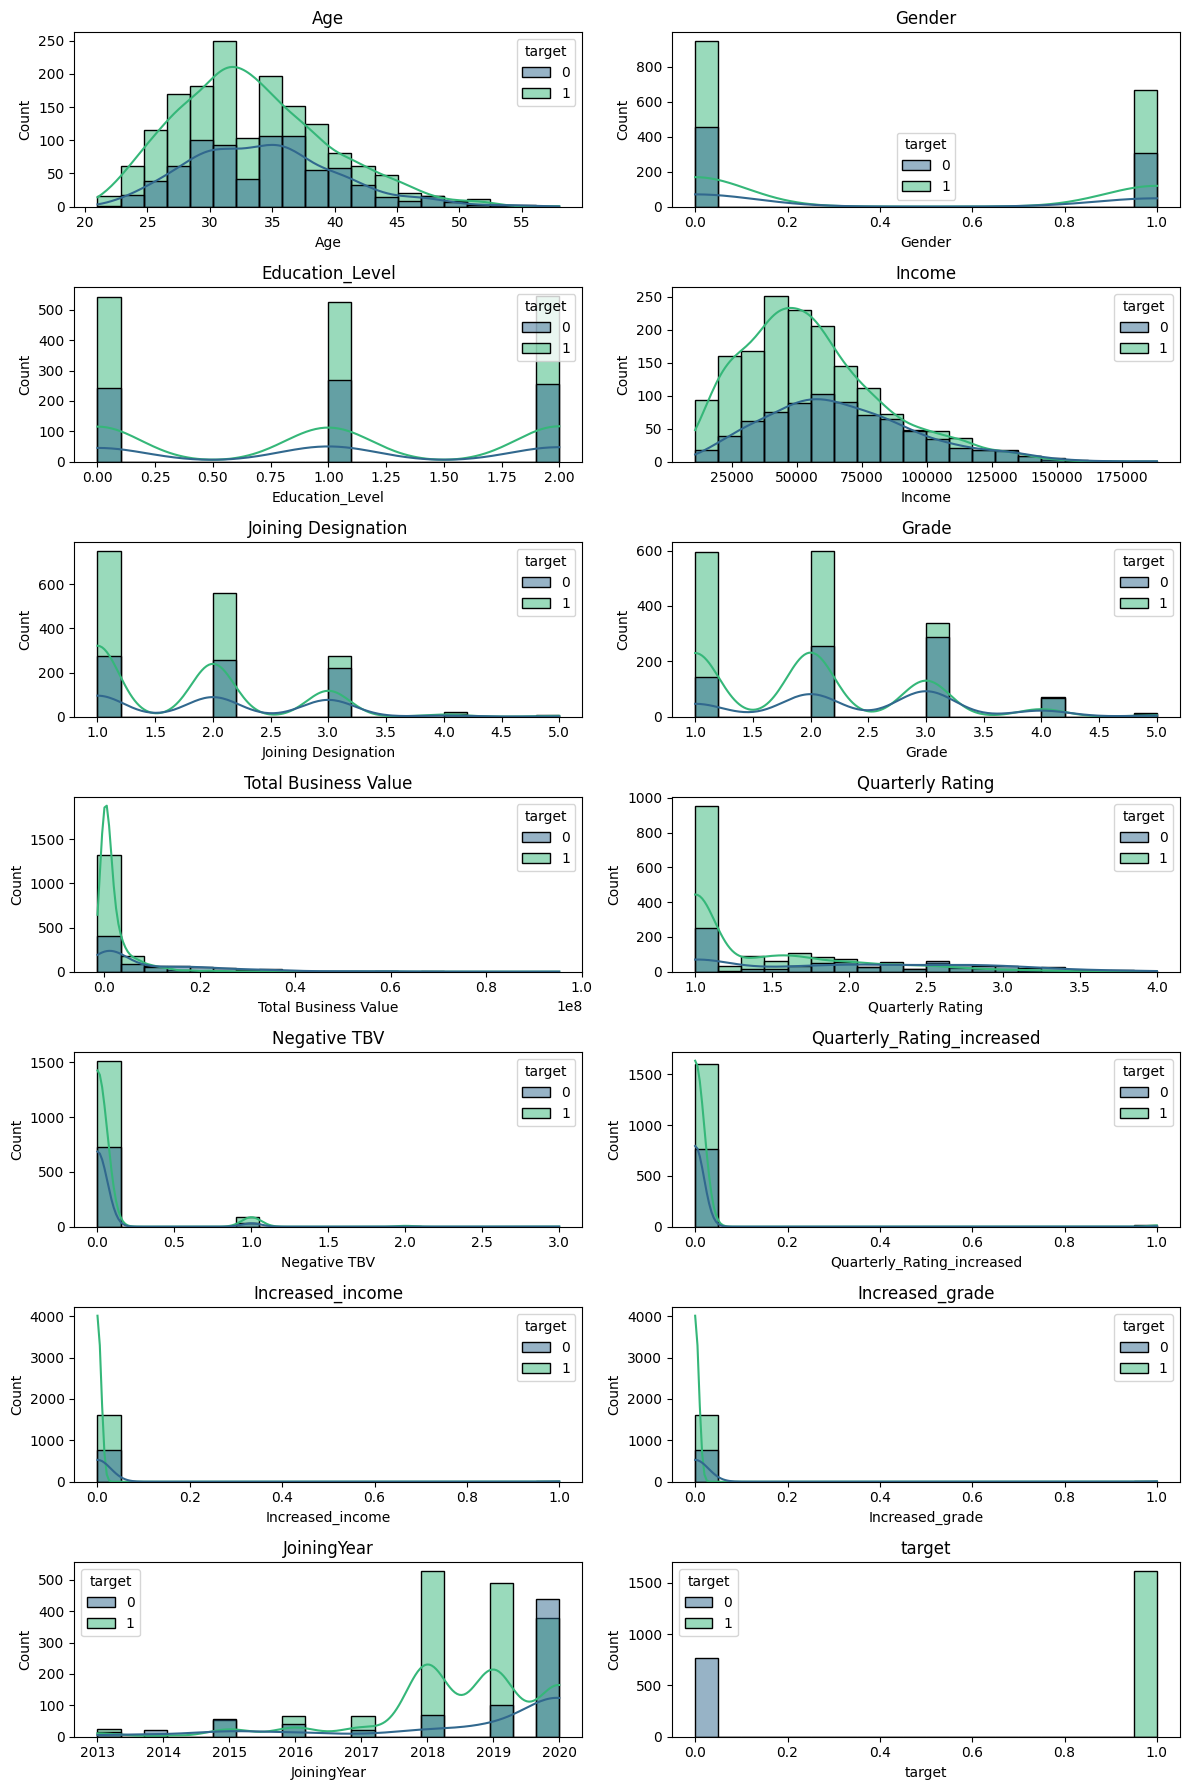

In [29]:
cols = df_grouped.select_dtypes(include=['int64', 'float64']).columns
# Calculate the number of rows and columns for subplots
num_cols = 2
num_rows = (len(cols) + 1) // 2

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 18))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms
for index, col in enumerate(cols):
    sns.histplot(data=df_grouped, x=col, bins=20, ax=axes[index], kde=True, hue='target', palette='viridis')
    axes[index].set_title(col)

plt.tight_layout()
plt.show()

<Axes: xlabel='Education_Level', ylabel='count'>

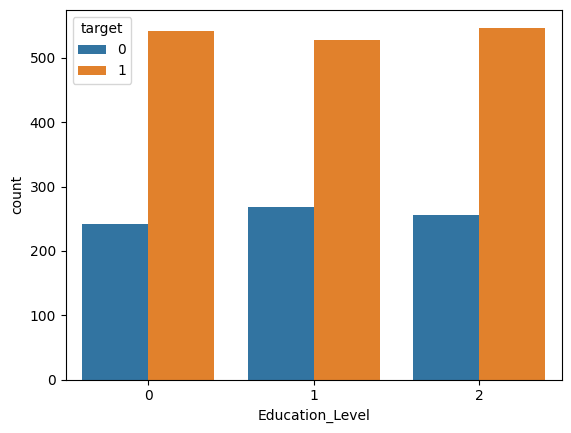

In [30]:
sns.countplot(data=df_grouped, x='Education_Level', hue='target')

<Axes: xlabel='Grade', ylabel='count'>

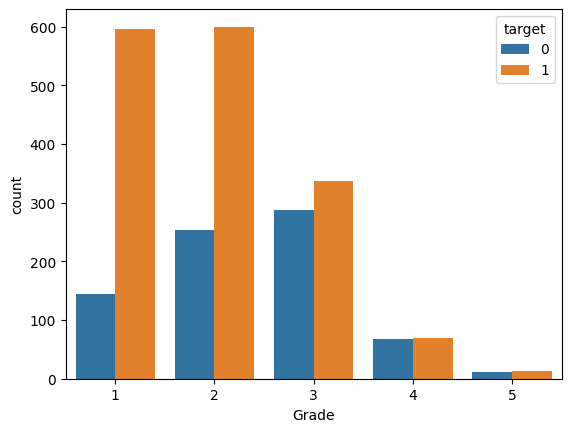

In [31]:
sns.countplot(data=df_grouped, x='Grade', hue='target')

<Axes: xlabel='City', ylabel='count'>

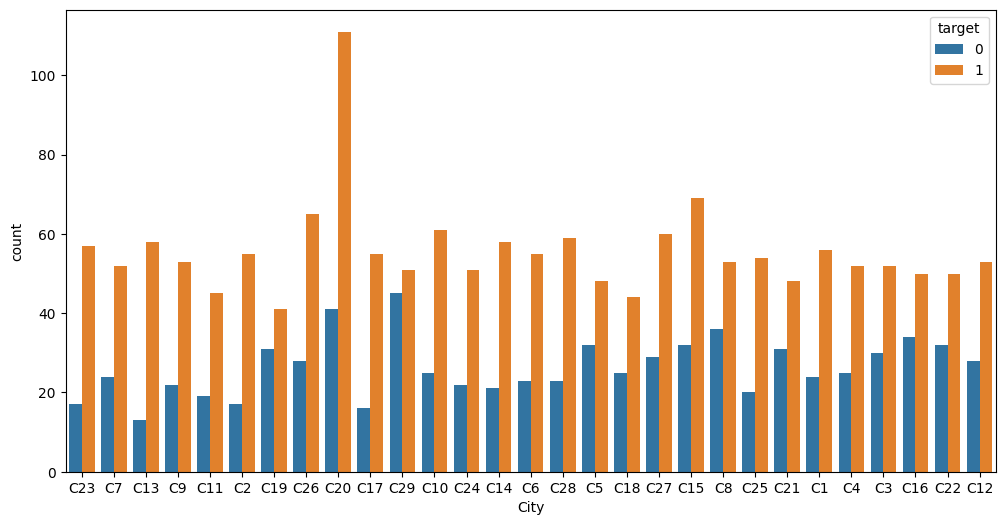

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_grouped, x='City', hue='target')

In [33]:
df_new = df_grouped[df_grouped['City']=='C20']

In [34]:
# % of Drivers leaving based on 'Education Level'
print('% of attrition based on Education Level')
print(round((df_new.groupby('Education_Level')['target'].mean())*100,2))

# % of Drivers leaving based on 'Grade'
print('% of attrition based on Grade')
print(round((df_new.groupby('Grade')['target'].mean())*100,2))

# Count of Drivers based on 'Grade'
print('Driver count by Grade')
print(df_new['Grade'].value_counts())

# Count of Drivers leaving based on 'Total Business Value'
print('Count of Drivers leaving based on Total Business Value')
print(round((df_new.groupby('target')['Total Business Value'].mean()),2))

% of attrition based on Education Level
Education_Level
0    77.78
1    65.22
2    75.00
Name: target, dtype: float64
% of attrition based on Grade
Grade
1     92.50
2     70.00
3     61.90
4     55.56
5    100.00
Name: target, dtype: float64
Driver count by Grade
2    60
3    42
1    40
4     9
5     1
Name: Grade, dtype: int64
Count of Drivers leaving based on Total Business Value
target
0    7368600.73
1    1533074.41
Name: Total Business Value, dtype: float64


In [35]:
df_grouped.describe()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Negative TBV,Quarterly_Rating_increased,Increased_income,Increased_grade,JoiningYear,target
count,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,33.663167,0.410332,1.00756,59232.460484,1.820244,2.097018,4.586742e+06,1.566304,0.062579,0.006720,0.004620,0.004620,2018.536329,0.678706
std,5.983375,0.491997,0.81629,28298.214012,0.841433,0.941702,9.127115e+06,0.719652,0.267006,0.081716,0.067827,0.067827,1.609597,0.467071
min,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,0.000000
25%,29.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,0.000000
50%,33.000000,0.000000,1.00000,55285.000000,2.000000,2.000000,8.176800e+05,1.000000,0.000000,0.000000,0.000000,0.000000,2019.000000,1.000000
75%,37.000000,1.000000,2.00000,75835.000000,2.000000,3.000000,4.173650e+06,2.000000,0.000000,0.000000,0.000000,0.000000,2020.000000,1.000000
max,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,9.533106e+07,4.000000,3.000000,1.000000,1.000000,1.000000,2020.000000,1.000000


## Bivariate Analysis

<Axes: xlabel='Grade', ylabel='Income'>

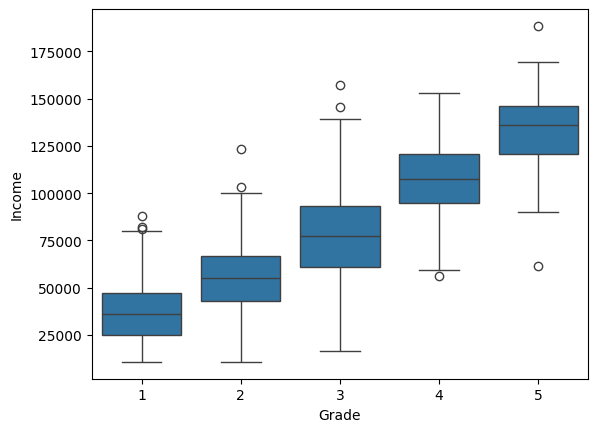

In [38]:
sns.boxplot(data=df_grouped, x='Grade', y='Income')

<Axes: xlabel='target', ylabel='Income'>

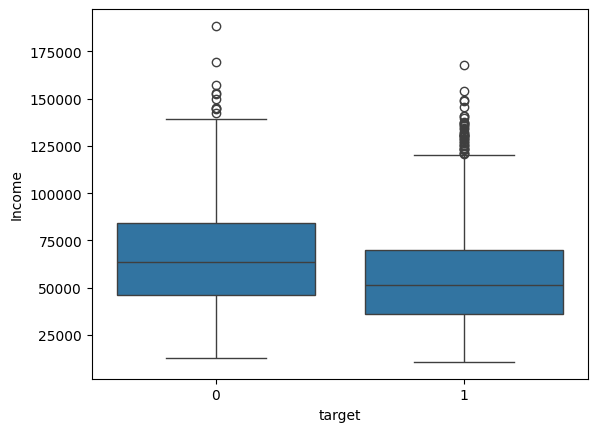

In [39]:
sns.boxplot(data=df_grouped, x='target', y='Income')

<Axes: xlabel='target', ylabel='Grade'>

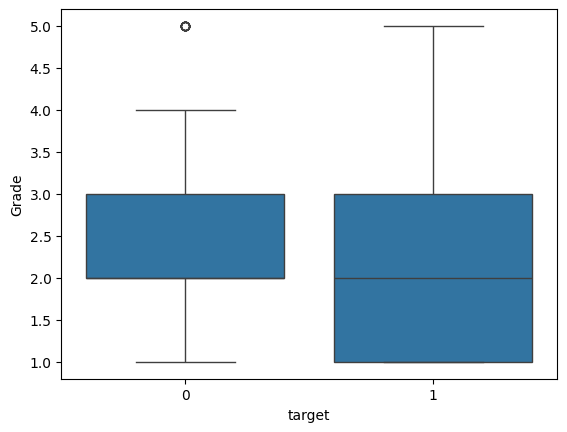

In [40]:
sns.boxplot(data=df_grouped, x='target', y='Grade')

<Axes: xlabel='target', ylabel='Total Business Value'>

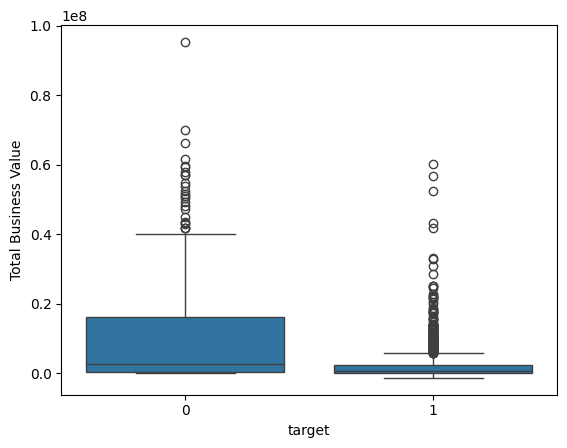

In [91]:
sns.boxplot(data=df_grouped, x='target', y='Total Business Value')

In [41]:
# def remove_outliers(df, features, threshold=1.5):
#     outlier_indices = []
#     for feature in features:
#         # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#         Q1 = df[feature].quantile(0.25)
#         Q3 = df[feature].quantile(0.75)
#         # Calculate IQR (Interquartile Range)
#         IQR = Q3 - Q1
#         # Define the outlier step
#         outlier_step = threshold * IQR
#         # Identify outlier indices
#         outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
#         # Append the found outlier indices for feature to the list of outlier indices
#         outlier_indices.extend(outlier_list_col)
#     # Remove the outlier indices from the dataset
#     df = df.drop(outlier_indices).reset_index(drop=True)
#     return df

# # Assuming df is your DataFrame and features is a list of numerical features
# # Apply the remove_outliers function to remove outliers from the specified features
# df_cleaned = remove_outliers(df, ['feature1', 'feature2', 'feature3'])

## Multivariate Analysis

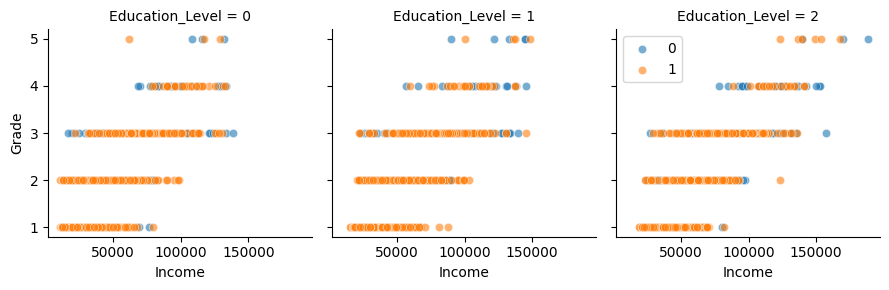

In [42]:
g = sns.FacetGrid(df_grouped, col='Education_Level', hue='target')

# Map a plot type to the FacetGrid
g.map(sns.scatterplot, 'Income', 'Grade', alpha=0.6)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.legend()
plt.show()

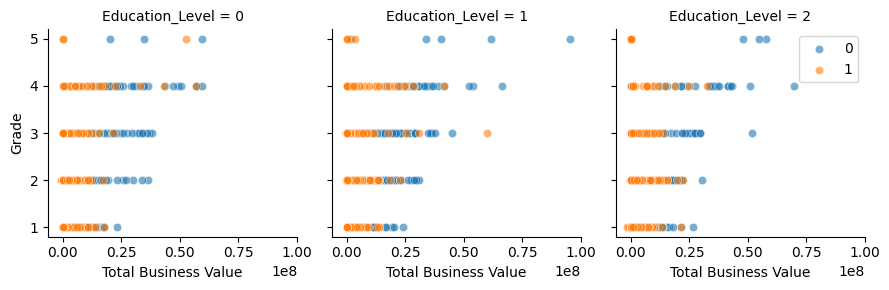

In [43]:
g = sns.FacetGrid(df_grouped, col='Education_Level', hue='target')

# Map a plot type to the FacetGrid
g.map(sns.scatterplot, 'Total Business Value', 'Grade', alpha=0.6)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.legend()
plt.show()

In [44]:
# bins1 = [-float('inf'), 50000, 100000, 150000, float('inf')]
# bins2 = [-float('inf'), 25000000, 50000000, float('inf')]
# # Define the bin labels
# labels1 = [0, 1, 2, 3]
# labels2 = [0, 1, 2]

# # Bin the 'Income' column into 4 bins
# df_grouped['Income_Bin'] = pd.cut(df_grouped['Income'], bins=bins1, labels=labels1, right=False)
# df_grouped['TBV_Bin'] = pd.cut(df_grouped['Total Business Value'], bins=bins2, labels=labels2, right=False)

In [45]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   MMM-YY                      2381 non-null   datetime64[ns]
 1   Age                         2381 non-null   float64       
 2   Gender                      2381 non-null   float64       
 3   City                        2381 non-null   object        
 4   Education_Level             2381 non-null   int64         
 5   Income                      2381 non-null   float64       
 6   Dateofjoining               2381 non-null   datetime64[ns]
 7   LastWorkingDate             1616 non-null   datetime64[ns]
 8   Joining Designation         2381 non-null   int64         
 9   Grade                       2381 non-null   int64         
 10  Total Business Value        2381 non-null   int64         
 11  Quarterly Rating            2381 non-null   float64     

In [46]:
# df_grouped['Income_Bin']=df_grouped['Income_Bin'].astype(int)
# df_grouped['TBV_Bin']=df_grouped['TBV_Bin'].astype(int)
# df_grouped['Inc2TBV2Grade']=df_grouped['Income_Bin']*df_grouped['TBV_Bin']*df_grouped['Grade']
# df_grouped['Age2Income']=df_grouped['Income_Bin']*df_grouped['Age']

<ipython-input-36-42d0c26a1c1a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_grouped.corr()


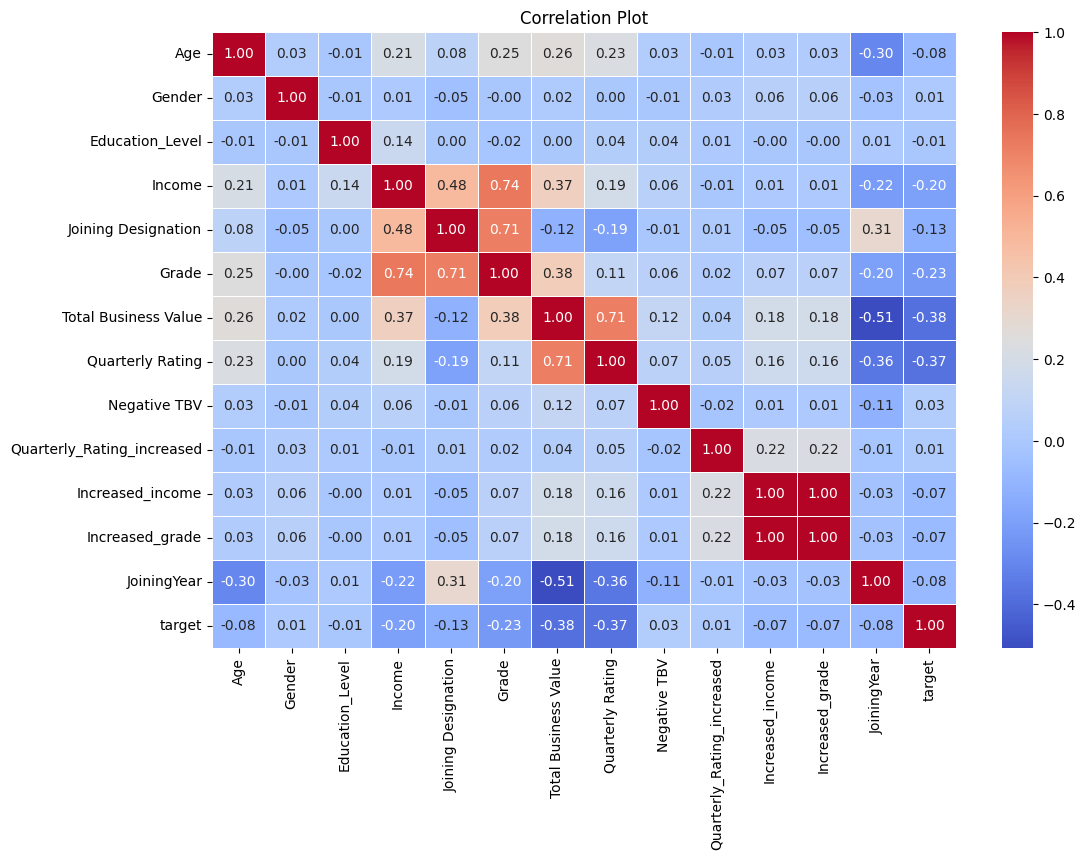

In [36]:
correlation_matrix = df_grouped.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

# Data Preprocessing

In [37]:
city_mapping = {
    'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5, 'C6': 6, 'C7': 7, 'C8': 8, 'C9': 9, 'C10': 10,
    'C11': 11, 'C12': 12, 'C13': 13, 'C14': 14, 'C15': 15, 'C16': 16, 'C17': 17, 'C18': 18, 'C19': 19, 'C20': 20,
    'C21': 21, 'C22': 22, 'C23': 23, 'C24': 24, 'C25': 25, 'C26': 26, 'C27': 27, 'C28': 28, 'C29': 29
}

# Map the cities using the dictionary
df_grouped['City'] = df_grouped['City'].map(city_mapping)

In [78]:
# Input and Target feature separation
X=df_grouped.drop(['target', 'MMM-YY', 'Dateofjoining', 'LastWorkingDate', 'Education_Level'], axis=1)
y=df_grouped['target']

In [79]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train is your training data and df_grouped contains the column names
cols = X.columns

# Initialize StandardScaler
scale = StandardScaler()

# Standardize the training data
X_scaled = scale.fit_transform(X)

# Convert the standardized data back to a DataFrame with column names
X_scaled = pd.DataFrame(data=X_scaled, columns=cols)

In [80]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [52]:
y_train.value_counts()

1    1289
0     615
Name: target, dtype: int64

In [82]:
# Define the RandomForest classifier
rf_classifier = RandomForestClassifier(n_estimators=60, n_jobs=-1, random_state = 42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the train and validation set
pred_train = rf_classifier.predict(X_train)
pred_test = rf_classifier.predict(X_test)

print(f'Train Accuracy: {accuracy_score(pred_train, y_train)}')
print(f'Validation Accuracy: {accuracy_score(pred_test, y_test)}')
# print(rf_classifier.oob_score_)

Train Accuracy: 0.9994747899159664
Validation Accuracy: 0.7945492662473794


In [54]:
# param_dist = {
#     'n_estimators': [100, 200, 500],  # Number of trees in the forest
#     'max_features': ['auto', 'sqrt'],   # Number of features to consider at every split
#     'min_samples_leaf': [1, 10, 20]         # Method of selecting samples for training each tree
# }

# # Create a RandomForestClassifier instance
# rf = RandomForestClassifier()

# # Instantiate the RandomizedSearchCV object
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=0, random_state=42, n_jobs=-1)

# # Fit the model
# random_search.fit(X_train, y_train)

# # Get the best parameters and best score
# print("Best Parameters:", random_search.best_params_)
# print("Best Score:", random_search.best_score_)

In [92]:
rf_classifier = RandomForestClassifier(n_estimators=50, min_samples_leaf= 20, n_jobs=-1, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the train and validation set
pred_train = rf_classifier.predict(X_train)
pred_test = rf_classifier.predict(X_test)

print(f'Train Accuracy: {accuracy_score(pred_train, y_train)}')
print(f'Validation Accuracy: {accuracy_score(pred_test, y_test)}')

Train Accuracy: 0.845063025210084
Validation Accuracy: 0.8155136268343816


In [93]:
for score, name in zip(rf_classifier.feature_importances_, X_train.columns):
  print(round(score,2),name)

0.02 Age
0.01 Gender
0.02 City
0.05 Income
0.04 Joining Designation
0.04 Grade
0.34 Total Business Value
0.17 Quarterly Rating
0.0 Negative TBV
0.0 Quarterly_Rating_increased
0.0 Increased_income
0.0 Increased_grade
0.31 JoiningYear


In [113]:
# Define the LightGBM classifier with hyperparameters
lgb_classifier = lgb.LGBMClassifier(n_estimators=100, boosting_type='gbdt', learning_rate=0.02, random_state=42)

# Train the classifier
lgb_classifier.fit(X_train, y_train)

# Predict on the train and validation set
pred_train = lgb_classifier.predict(X_train)
pred_test = lgb_classifier.predict(X_test)

# Evaluate the model
print(f'Train Accuracy: {accuracy_score(pred_train, y_train)}')
print(f'Validation Accuracy: {accuracy_score(pred_test, y_test)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1289, number of negative: 615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.676996 -> initscore=0.740000
[LightGBM] [Info] Start training from score 0.740000
Train Accuracy: 0.895483193277311
Validation Accuracy: 0.7945492662473794


In [130]:
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=250, learning_rate=0.09, random_state=42)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Predict on the train and validation set
pred_train = xgb_classifier.predict(X_train)
pred_test = xgb_classifier.predict(X_test)

# Evaluate the model
print(f'Train Accuracy: {accuracy_score(pred_train, y_train)}')
print(f'Validation Accuracy: {accuracy_score(pred_test, y_test)}')

Train Accuracy: 0.9921218487394958
Validation Accuracy: 0.7924528301886793


In [197]:
from sklearn.ensemble import AdaBoostClassifier

# Instantiate the AdaBoost classifier
adaboost_clf = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, random_state=42)  # You can specify the number of estimators (weak learners)

# Fit the classifier to the training data
adaboost_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = adaboost_clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8134171907756813


In [206]:
# Define the Voting Classifier with the base classifiers
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', rf_classifier),
        ('lgb', lgb_classifier),
        ('ada', adaboost_clf),
        ('xgb', xgb_classifier)
    ],
    voting='hard',
    n_jobs=-1,
    weights=[1,0.9,1,1] # 'hard' voting means majority voting
)

# Train the Voting Classifier
voting_classifier.fit(X_train, y_train)

# Predict on the test set
pred_train = voting_classifier.predict(X_train)
pred_test = voting_classifier.predict(X_test)

# Evaluate the model
print(f'Train Accuracy: {accuracy_score(pred_train, y_train)}')
print(f'Validation Accuracy: {accuracy_score(pred_test, y_test)}')

Train Accuracy: 0.8660714285714286
Validation Accuracy: 0.8176100628930818


In [166]:
from sklearn.svm import SVC

# Instantiate the SVM classifier
svm_clf = SVC(C=2.5, kernel='rbf')  # You can choose different kernels such as 'linear', 'rbf', 'poly', etc.

# Fit the classifier to the training data
svm_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8050314465408805


# PCA

In [61]:
# Input and Target feature separation
X=df_grouped.drop(['target', 'MMM-YY', 'Dateofjoining', 'LastWorkingDate'], axis=1)
y=df_grouped['target']

In [62]:
from sklearn.decomposition import PCA

# Assuming df is your DataFrame containing the features you want to reduce

# Instantiate the PCA object
pca = PCA(n_components=5)  # Specify the number of components (dimensions) you want to reduce to

# Fit PCA to your data and transform it
df_pca = pca.fit_transform(X)

# Convert the transformed array back to a DataFrame
X = pd.DataFrame(df_pca)  # Replace 'PC1' and 'PC2' with meaningful names if needed

In [63]:
# Assuming X_train is your training data and df_grouped contains the column names
cols = X.columns

# Initialize StandardScaler
scale = StandardScaler()

# Standardize the training data
X_scaled = scale.fit_transform(X)

# Convert the standardized data back to a DataFrame with column names
X_scaled = pd.DataFrame(data=X_scaled, columns=cols)

In [64]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [65]:
rf_classifier = RandomForestClassifier(n_estimators=200, min_samples_leaf= 20, n_jobs=-1, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the train and validation set
pred_train = rf_classifier.predict(X_train)
pred_test = rf_classifier.predict(X_test)

print(f'Train Accuracy: {accuracy_score(pred_train, y_train)}')
print(f'Validation Accuracy: {accuracy_score(pred_test, y_test)}')

Train Accuracy: 0.8671218487394958
Validation Accuracy: 0.7672955974842768


In [66]:
from sklearn.svm import SVC

# Instantiate the SVM classifier
svm_clf = SVC(kernel='linear')  # You can choose different kernels such as 'linear', 'rbf', 'poly', etc.

# Fit the classifier to the training data
svm_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = svm_clf.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7484276729559748
